# Import libraries

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [19]:
print(tf.__version__)

2.19.0


In [20]:
#filename = "data\yes bilder isabelle//2491975_1119775.jpg"

# Train-Test Split
80% - 20%

momentan insgesamt je 300 Bilder --> dh. 240 für Training, 60 Testing

# Loading data

In [31]:
labels = ['no', 'yes'] # yes: green electro parking spot
# 'no' = 0, 'yes' = 1
img_size = 224  # Zielgrösse Bilder           

def get_data(data_dir):
    X = []  # Bilddaten
    y = []  # zugehörigen Labels 0 oder 1 

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]    # Bild einlesen, in RGB umwandeln 
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Bild auf einheitliche Grösse skalieren
                X.append(resized_arr)
                y.append(class_num)
            except Exception as e:
                print(f"Fehler bei {img}: {e}")

    return np.array(X), np.array(y)

In [32]:
# alle Daten laden 
train_X, train_y = get_data('dataset/train')   # X=Bild, y=Label 
val_X, val_y = get_data('dataset/test')        # 0 für no, 1 für yes

print("Train shape:", train_X.shape, train_y.shape)
print("Val shape:", val_X.shape, val_y.shape)

# Beispiel-Labels anzeigen 
print("\nLabel-Beispiel1:", train_y[0], "→", labels[train_y[0]])
print("Label-Beispiel2:", train_y[-1], "→", labels[train_y[-1]])

# Anzahl Daten
print("\nLänge Trainingsdaten:", len(train_X))   # hier 480 Bilder
print("Länge Labels:", len(train_y))   # sollte genauso viele Labels haben wie train_X


Train shape: (480, 224, 224, 3) (480,)
Val shape: (120, 224, 224, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480


# Visualize data

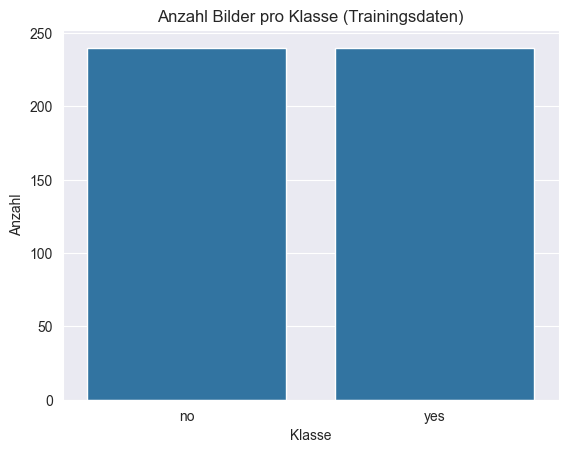

In [33]:
l = []
for i in train_y:   # train_y sind Labels 0 oder 1 
    if i == 0:
        l.append("no")
    else:
        l.append("yes")
        
sns.set_style('darkgrid')
sns.countplot(x=l)
plt.title("Anzahl Bilder pro Klasse (Trainingsdaten)")
plt.xlabel("Klasse")
plt.ylabel("Anzahl")
plt.show()

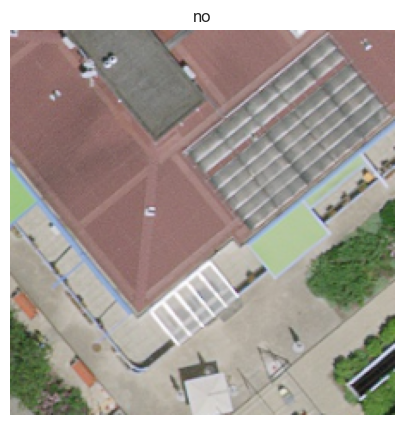

In [34]:
plt.figure(figsize = (5,5))
plt.imshow(train_X[0])  # Bilddaten, hier z.B. erstes Bild 
plt.title(labels[train_y[0]])   # Klassentext: yes or no 
plt.axis('off')
plt.show()

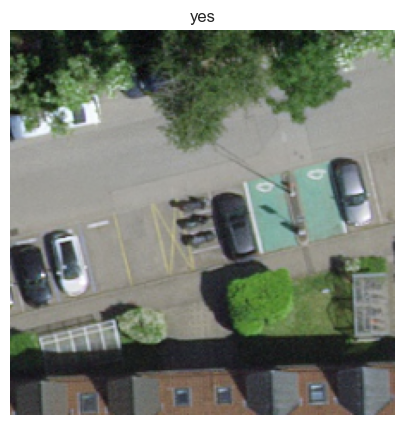

In [36]:
plt.figure(figsize=(5, 5))
plt.imshow(train_X[240]) # 241. Bild im Datensatz = 1. yes Bild 
plt.title(labels[train_y[-1]])  # Label anzeigen: yes or no 
plt.axis('off')
plt.show()

# Data Preprocessing and Data Augmentation 

In [37]:
# Bilder drehen und spiegel aus 1 Orginalbild -> 12 Testbilder 
def rotate_and_flip_images(x, y):
    x_aug, y_aug = [], []
    for img, label in zip(x, y):
        for k in range(4):  # 0°, 90°, 180°, 270°
            rotated = np.rot90(img, k=k)
            x_aug.append(rotated); y_aug.append(label)
            x_aug.append(np.fliplr(rotated)); y_aug.append(label)  # Horizontal Flip
            x_aug.append(np.flipud(rotated)); y_aug.append(label)  # Vertical Flip
    return np.array(x_aug), np.array(y_aug)

In [ ]:
# Augmentieren: Drehen und Flippen
x_train, y_train = rotate_and_flip_images(train_X, train_y)

# Normalisieren --> Pixelwerte von 0-255 enspricht 0-1
x_train = x_train / 255.0
x_val = val_X / 255.0

# Labels als float32 für binary_crossentropy
y_train = y_train.astype('float32')
y_val = val_y.astype('float32')

# Kontrolle
print("Train X:", x_train.shape)    # 480 Originalbilder *12 = 5760
print("Train y:", y_train.shape)
print("Val X:", x_val.shape)        # 120 echte Testbilder 
print("Val y:", y_val.shape)
print(set(y_train))

Train X: (5760, 224, 224, 3)
Train y: (5760,)
Val X: (120, 224, 224, 3)
Val y: (120,)
{np.float32(0.0), np.float32(1.0)}


In [28]:
# Data Augmentation für Trainingsdaten
'''
datagen = ImageDataGenerator(   # erstellt zufällige Varianten der Trainingsbilder 
    rotation_range = 30,    # Bilder leicht drehen um Winkel 
    zoom_range = 0.2,       # reinzoomen 
    width_shift_range = 0.1,    # horizontal verschieben 
    height_shift_range = 0.1,   # vertikal verschieben
    horizontal_flip = False,     # spiegeln
    vertical_flip = True       # nicht auf den Kopf stellen
)

datagen.fit(x_train)
'''

'\ndatagen = ImageDataGenerator(   # erstellt zufällige Varianten der Trainingsbilder \n    rotation_range = 30,    # Bilder leicht drehen um Winkel \n    zoom_range = 0.2,       # reinzoomen \n    width_shift_range = 0.1,    # horizontal verschieben \n    height_shift_range = 0.1,   # vertikal verschieben\n    horizontal_flip = False,     # spiegeln\n    vertical_flip = True       # nicht auf den Kopf stellen\n)\n\ndatagen.fit(x_train)\n'

# Define the Model

In [39]:
model = Sequential()

# 1. Convolutional Layer 
model.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

# 2. Convolutional Layer 
model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
model.add(MaxPool2D())

# 3. Convolutional Layer + Dropout gegen Overfitting 
model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

# Dense Schichten 
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))   # sigmoid für Binary Classification 

model.summary()     # Modellübersicht 

c:\Users\isabe\anaconda3\envs\green_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,451,425 (24.61 MB)

 Trainable params: 6,451,425 (24.61 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Optimizer 
opt = Adam(learning_rate=0.0001)   # Lernrate gibt an wie stark Modell seine Gewichte anpasst 

# Modell kompilieren 
model.compile(
    optimizer = opt, 
    loss = 'binary_crossentropy',   # für 2-Klassen Probleme 
    metrics = ['accuracy'])

# Training 
history = model.fit(
    x_train, y_train,
    batch_size = 32, 
    epochs = 50,    # max. 50 Runden 
    validation_data = (x_val, y_val),   # für Modellbewertung 
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]  # beendet Training, wenn sich val_loss 5 Epochen lang nicht mehr verbessert -> verhindert Overfitting 
)


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 84s 448ms/step - accuracy: 0.5277 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6832
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 74s 411ms/step - accuracy: 0.6379 - loss: 0.6398 - val_accuracy: 0.7167 - val_loss: 0.5968
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 75s 416ms/step - accuracy: 0.6532 - loss: 0.6144 - val_accuracy: 0.7000 - val_loss: 0.5929
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 80s 446ms/step - accuracy: 0.7007 - loss: 0.5696 - val_accuracy: 0.6917 - val_loss: 0.5952
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 74s 413ms/step - accuracy: 0.7507 - loss: 0.5278 - val_accuracy: 0.6333 - val_loss: 0.6694
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 80s 442ms/step - accuracy: 0.7280 - loss: 0.5248 - val_accuracy: 0.6500 - val_loss: 0.6422
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 77s 428ms/step - accuracy: 0.7795 - loss: 0.4664 - val_accuracy: 0.6750 - val_loss: 0.6299
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 76s 419ms/step - accuracy: 0.8133 - loss: 0

# Evaluating results

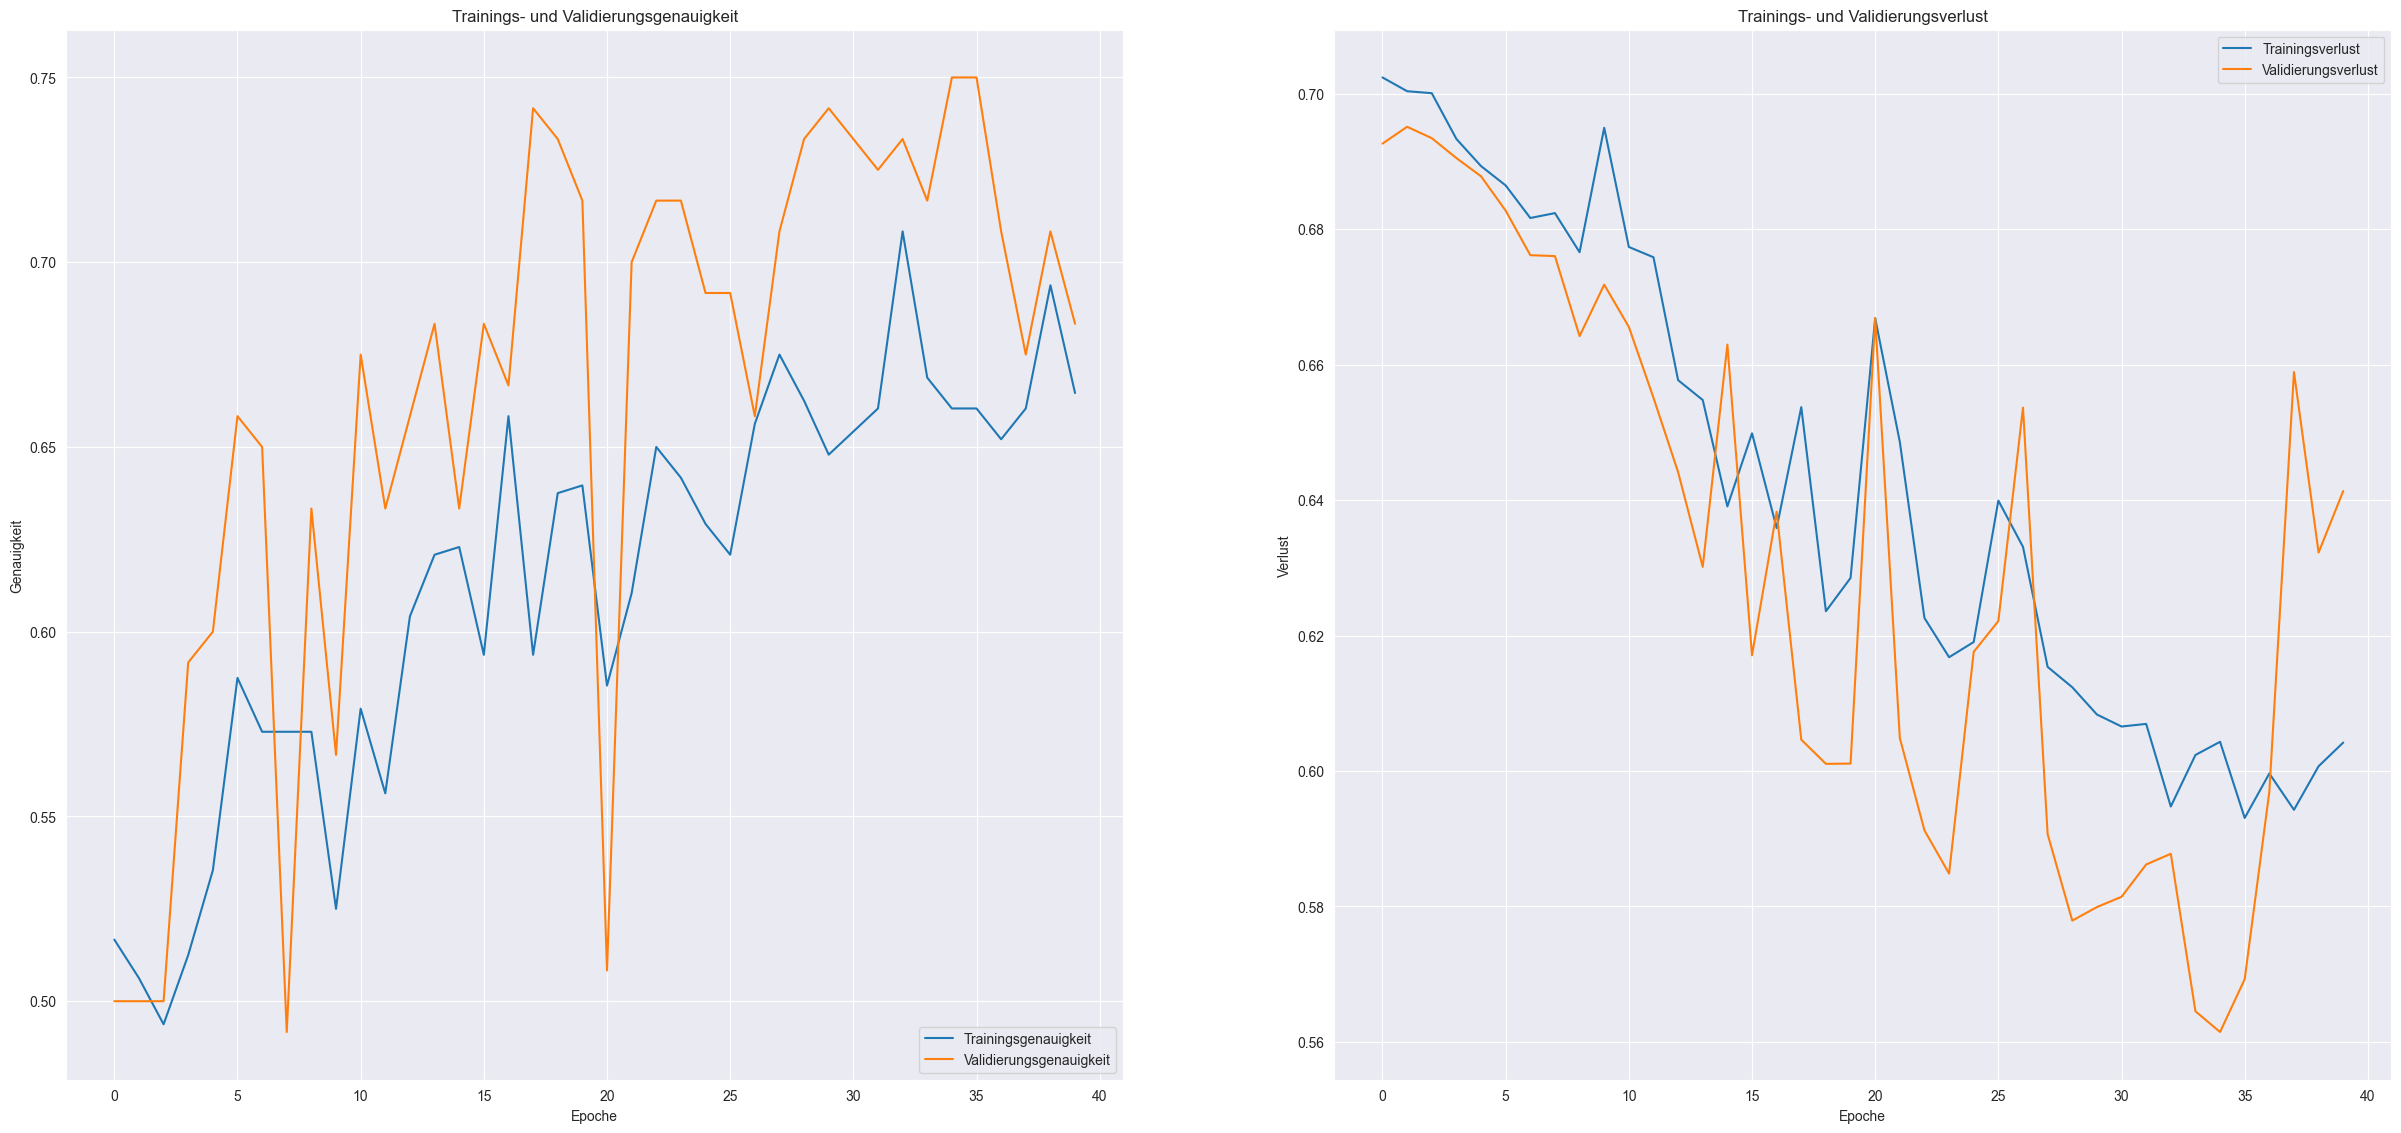

In [ ]:
import matplotlib.pyplot as plt

# Trainingsverlauf aus dem History-Objekt auslesen
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Automatisch richtige Länge der x-Achse
epochs_range = range(len(acc))

# Plot erstellen
plt.figure(figsize=(30, 30))

# Accuracy-Plot
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Trainingsgenauigkeit')
plt.plot(epochs_range, val_acc, label='Validierungsgenauigkeit')
plt.legend(loc='lower right')
plt.title('Trainings- und Validierungsgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')

# Loss-Plot
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Trainingsverlust')
plt.plot(epochs_range, val_loss, label='Validierungsverlust')
plt.legend(loc='upper right')
plt.title('Trainings- und Validierungsverlust')
plt.xlabel('Epoche')
plt.ylabel('Verlust')

plt.show()


In [ ]:
# Vorhersagen (Wahrscheinlichkeiten zwischen 0 und 1)
predictions = model.predict(x_val)

# Schwelle: ab 0.5 → Klasse 1 (ja = grüner Parkplatz), sonst Klasse 0
predictions = (predictions > 0.5).astype("int32").reshape(-1)

# Klassifikationsbericht anzeigen
print(classification_report(y_val, predictions, target_names=['kein E-Parkplatz (0)', 'grüner E-Parkplatz (1)']))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
                        precision    recall  f1-score   support

  kein E-Parkplatz (0)       0.74      0.77      0.75        60
grüner E-Parkplatz (1)       0.76      0.73      0.75        60

              accuracy                           0.75       120
             macro avg       0.75      0.75      0.75       120
          weighted avg       0.75      0.75      0.75       120



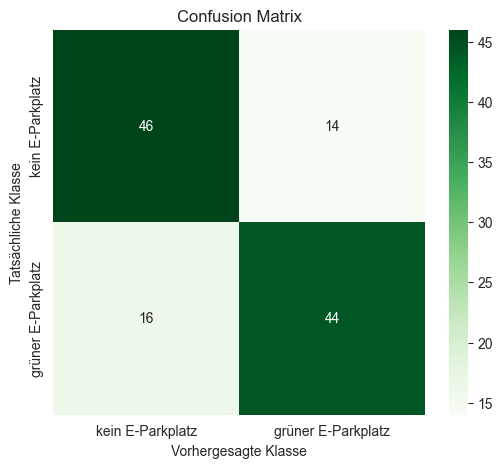

In [ ]:
# Confusion Matrix berechnen
cm = confusion_matrix(y_val, predictions)

# Klassenbezeichnungen
labels = ['kein E-Parkplatz', 'grüner E-Parkplatz']

# Plot anzeigen
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Vorhergesagte Klasse')  
plt.ylabel('Tatsächliche Klasse')
plt.title('Confusion Matrix')
plt.show()
# TN    FP
# FN    TP